## BigQuery NYC Taxi Data EDA (Time)
### Goals
- EDA of NYC taxi data with focus on time and demand
    - Number of calls by hour
    - Number of calls by day of week
    - Visualizations

### Import Modules

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import cufflinks as cf
import plotly.offline
cf.go_offline()
cf.set_config_file(offline=False, world_readable=True)

import warnings
warnings.filterwarnings("ignore")

plt.style.use('ggplot')
%matplotlib inline

### Load BigQuery NYC Taxi Data

In [2]:
from google.cloud import bigquery

# Create a "Client" object
client = bigquery.Client()

Using Kaggle's public dataset BigQuery integration.


In [3]:
dataset_ref = client.dataset('new_york_taxi_trips' ,project='bigquery-public-data')
dataset = client.get_dataset(dataset_ref)

In [4]:
tables = list(client.list_tables(dataset))
table_list = [table.table_id for table in tables]
table_list

['taxi_zone_geom',
 'tlc_fhv_trips_2015',
 'tlc_fhv_trips_2016',
 'tlc_fhv_trips_2017',
 'tlc_green_trips_2014',
 'tlc_green_trips_2015',
 'tlc_green_trips_2016',
 'tlc_green_trips_2017',
 'tlc_green_trips_2018',
 'tlc_yellow_trips_2015',
 'tlc_yellow_trips_2016',
 'tlc_yellow_trips_2017',
 'tlc_yellow_trips_2018']

In [5]:
table_ref = dataset.table('tlc_yellow_trips_2015')
table = client.get_table(table_ref)

In [6]:
client.list_rows(table, max_results = 5).to_dataframe()

,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,trip_distance,pickup_longitude,pickup_latitude,rate_code,store_and_fwd_flag,dropoff_longitude,dropoff_latitude,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,imp_surcharge,total_amount
0,2,2015-10-19 14:42:59,2015-10-19 14:47:06,2,0.65,-73.964737,40.767078,1.0,N,-73.962372,40.773129,2,5.0,0.0,0.5,0.00,0.0,0.3,5.80
1,1,2015-11-24 12:28:25,2015-11-24 12:37:33,1,0.60,-73.985336,40.744019,1.0,N,-73.991112,40.748569,1,7.0,0.0,0.5,1.55,0.0,0.3,9.35
2,2,2015-11-21 20:21:37,2015-11-21 20:44:19,1,2.65,-73.972588,40.755905,1.0,N,-74.000000,40.730560,2,15.0,0.5,0.5,0.00,0.0,0.3,16.30
3,1,2015-08-20 15:19:46,2015-08-20 15:23:58,1,0.60,-73.989464,40.767578,1.0,N,-73.978683,40.765167,2,4.5,0.0,0.5,0.00,0.0,0.3,5.30
4,2,2015-01-08 20:59:40,2015-01-08 21:09:31,1,1.74,-73.983673,40.765610,NaN,N,-73.976959,40.785778,2,9.0,0.5,0.5,0.00,0.0,0.3,10.30


### Trips in January
Count number of trips by pickup hours for trips in January 2015.

In [7]:
%%time
query = '''
        SELECT DATETIME_TRUNC(pickup_datetime, hour) AS pickup_hour,
               COUNT(1) AS cnt
        FROM `bigquery-public-data.new_york_taxi_trips.tlc_yellow_trips_2015`
        WHERE EXTRACT(MONTH FROM pickup_datetime) = 1
        GROUP BY pickup_hour
        ORDER BY pickup_hour
        '''

safe_config = bigquery.QueryJobConfig(maximum_bytes_billed = 10**10)

# Set up the query (will only run if it's less than 1 GB)
query_job = client.query(query, job_config=safe_config)

# API request - try to run the query, and return a pandas DataFrame
df = query_job.to_dataframe()
df.head()

CPU times: user 45.2 ms, sys: 2.2 ms, total: 47.4 ms
Wall time: 2.98 s


,pickup_hour,cnt
0,2015-01-01 00:00:00,28312
1,2015-01-01 01:00:00,31707
2,2015-01-01 02:00:00,28068
3,2015-01-01 03:00:00,24288
4,2015-01-01 04:00:00,17081


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 744 entries, 0 to 743
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   pickup_hour  744 non-null    datetime64[ns]
 1   cnt          744 non-null    int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 11.8 KB


In [9]:
df.set_index('pickup_hour', inplace=True)

In [11]:
df.iplot('scatter', xTitle='Datetimes', yTitle='Demand', title='NYC Taxi Demand (2015-01)')

Dip on January 27th due to [January 2015 North American blizzard](https://en.wikipedia.org/wiki/January_2015_North_American_blizzard).

### Trips by Date

In [12]:
df['date'] = df.index.date

In [13]:
df.head()

,cnt,date
pickup_hour,,
2015-01-01 00:00:00,28312,2015-01-01
2015-01-01 01:00:00,31707,2015-01-01
2015-01-01 02:00:00,28068,2015-01-01
2015-01-01 03:00:00,24288,2015-01-01
2015-01-01 04:00:00,17081,2015-01-01


In [14]:
df.groupby(['date'])[['cnt']].sum().iplot(xTitle='Date', yTitle='Count', title='Trips by Date')

### More Time Features

In [15]:
df['dow'] = df.index.dayofweek
df['week'] = df.index.week
df['hour'] = df.index.hour

In [16]:
df.head()

,cnt,date,dow,week,hour
pickup_hour,,,,,
2015-01-01 00:00:00,28312,2015-01-01,3,1,0
2015-01-01 01:00:00,31707,2015-01-01,3,1,1
2015-01-01 02:00:00,28068,2015-01-01,3,1,2
2015-01-01 03:00:00,24288,2015-01-01,3,1,3
2015-01-01 04:00:00,17081,2015-01-01,3,1,4


### Trips by Hour

In [17]:
df.groupby('hour')['cnt'].sum().iplot(xTitle='Hour', yTitle='Mean Count', title='Trips by Hour')

- Peak: 18~19
- Off-peak: 5

### Trips by Hour and Day of Week

In [18]:
df.groupby(['hour','dow'])['cnt'].mean().unstack()

dow,0,1,2,3,4,5,6
hour,,,,,,,
0,8552.75,6719.25,8787.00,14326.4,14054.2,25487.2,26099.00
1,5360.50,3707.00,5283.25,11440.4,8785.6,21118.6,22754.75
2,3675.25,2361.75,3337.75,8753.6,5856.8,16382.0,18918.00
3,2730.00,1504.00,2307.00,7030.2,3948.6,12112.0,14226.50
4,2691.25,1633.75,2297.25,5444.8,3341.8,7730.4,8549.25
5,4134.25,3159.00,4057.75,5198.2,4150.0,3911.8,3933.25
6,10065.25,8757.25,11587.00,10925.0,10476.0,4775.6,3983.50
7,16805.75,15820.50,21199.25,18754.0,18194.6,6866.8,5437.00
8,20491.50,19087.25,25219.00,21822.0,21141.8,10864.2,8367.75


In [19]:
dow_dict = {0:'Mon',1:'Tue',2:'Wed',3:'Thu',4:'Fri',5:'Sat',6:'Sun'}
df.groupby(['hour','dow'])['cnt'].mean().unstack().rename(columns=dow_dict).iplot(
    xTitle='Hour', yTitle='Mean Count', title='Trips by Hour and Day of Week')

Trends in line 5 (Saturdays) and 6 (Sundays) look somewhat similar, and trends the other lines look somewhat similar. Click on the legend to make each line visible/invisible. Let's look into more details of trends related to day of week in the following sections.

### Trips by Day of Week

In [20]:
df.groupby('dow')[['cnt']].mean().rename(index=dow_dict).iplot(kind='bar', xTitle='Day of Week', yTitle='Mean Count', title='Trips by Day of Week')

In [21]:
df['is_weekend'] = df['dow'] // 5

In [22]:
df.groupby(['hour','is_weekend'])['cnt'].mean().unstack().rename(columns={0:'Weekday', 1:'Weekend'}).iplot(xTitle='Hour', yTitle='Mean Count', title='Trips by Hour (Weekdays/Weekends)')

See differences in trends of weekends and weekdays. On weekdays, more calls are in the morning and evening. On weekends, calls ten to increase in late hours.

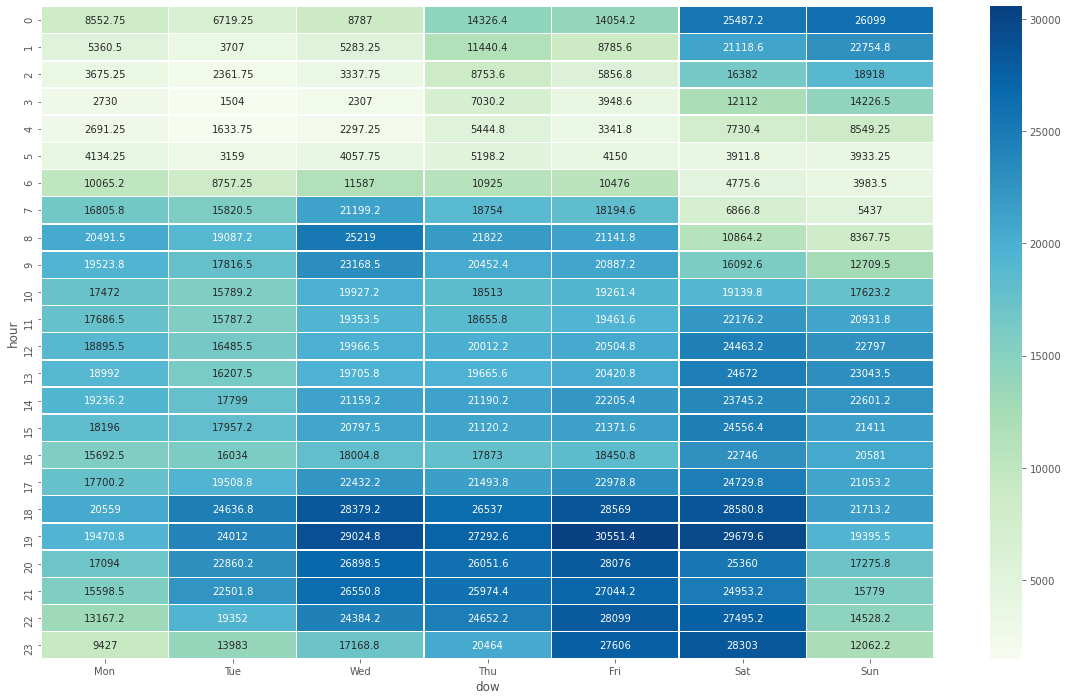

In [23]:
plt.figure(figsize = (20, 12))
sns.heatmap(df.groupby(['hour', 'dow'])['cnt'].mean().unstack().rename(columns=dow_dict),lw=.5, annot=True, cmap='GnBu', fmt='g', annot_kws={'size':10});

See which parts of the heatmap have similar colors and trends. Similar trends on Saturdays and Sundays in the morning and in the afternoon. Fridays and Saturdays show similar trends at night. Generally more rides Friday~Sunday.

### Hourly Boxplots

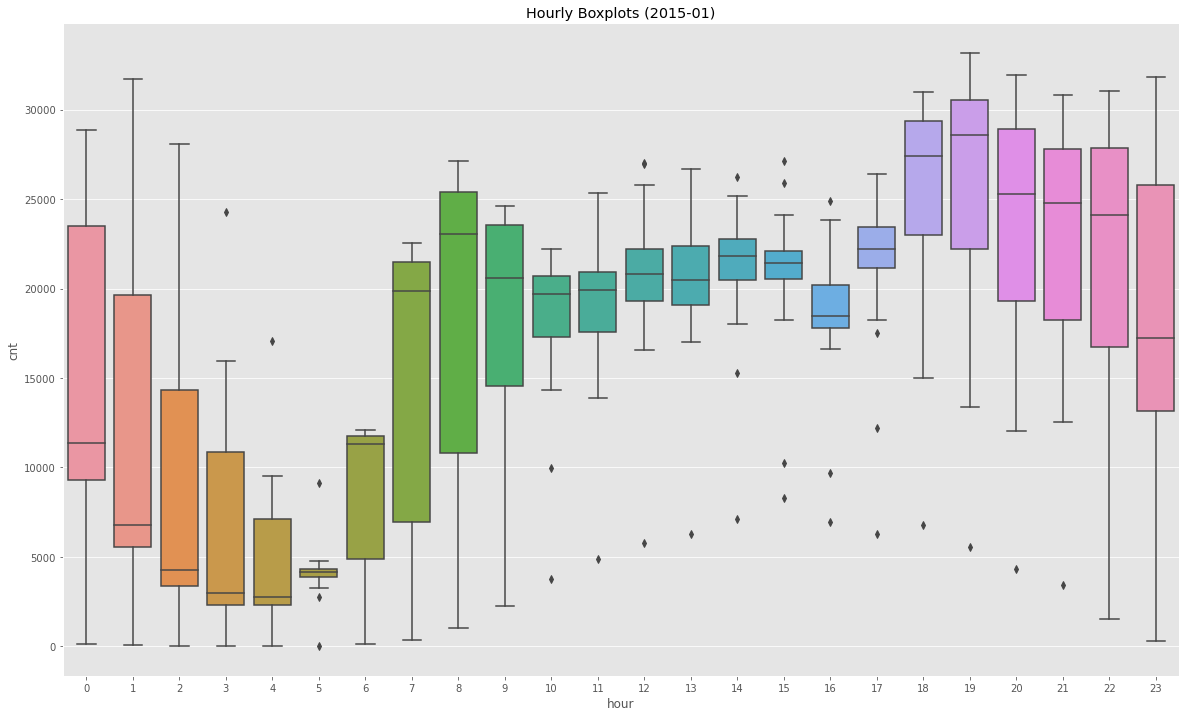

In [24]:
plt.figure(figsize=(20,12))
sns.boxplot(x='hour',y='cnt',data=df)
plt.title('Hourly Boxplots (2015-01)');

### Hourly Boxplots by Week

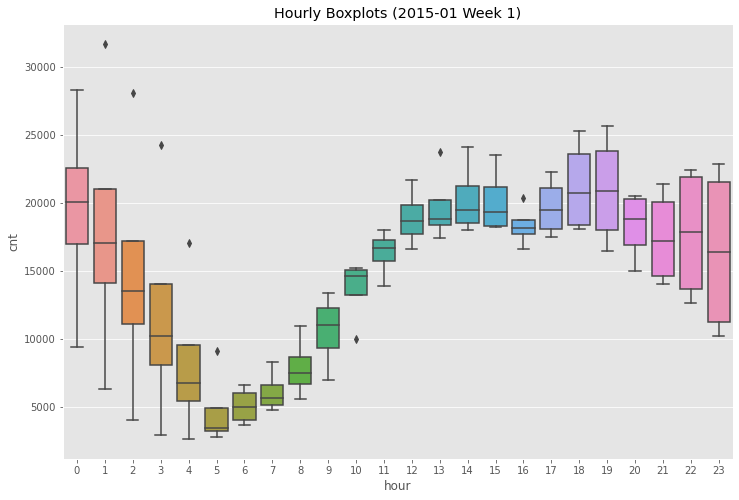

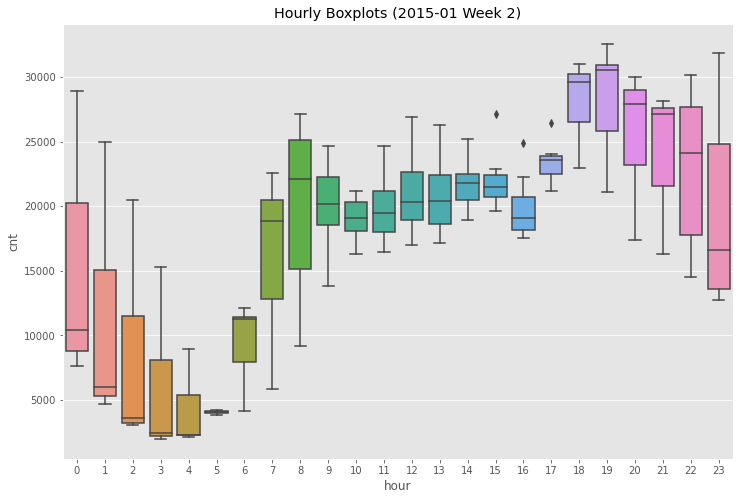

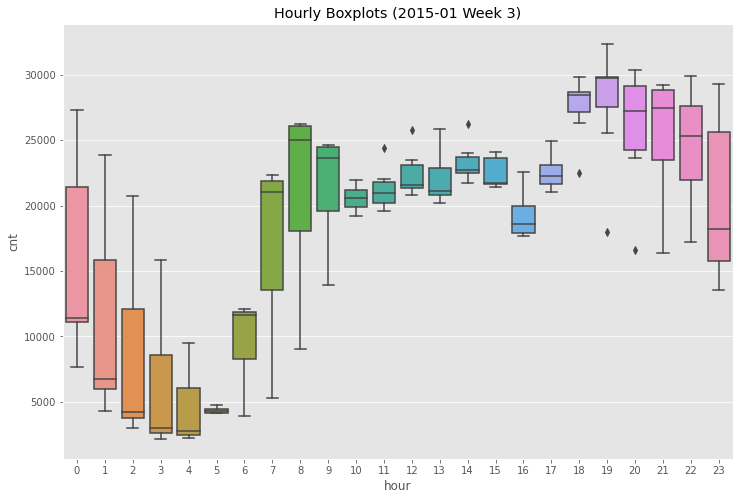

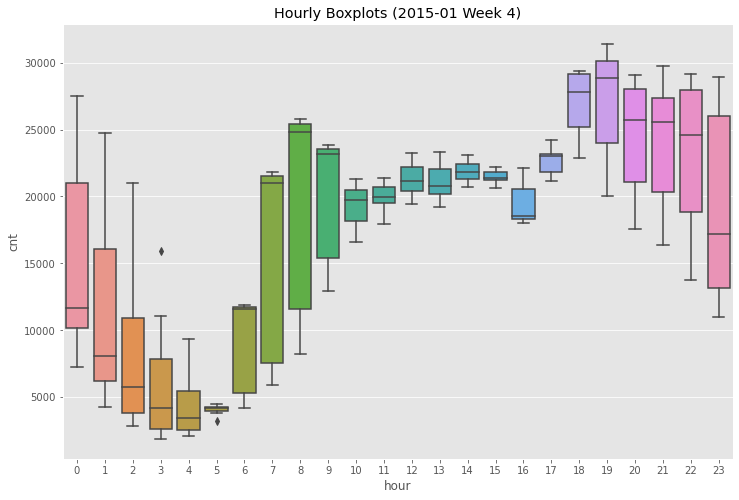

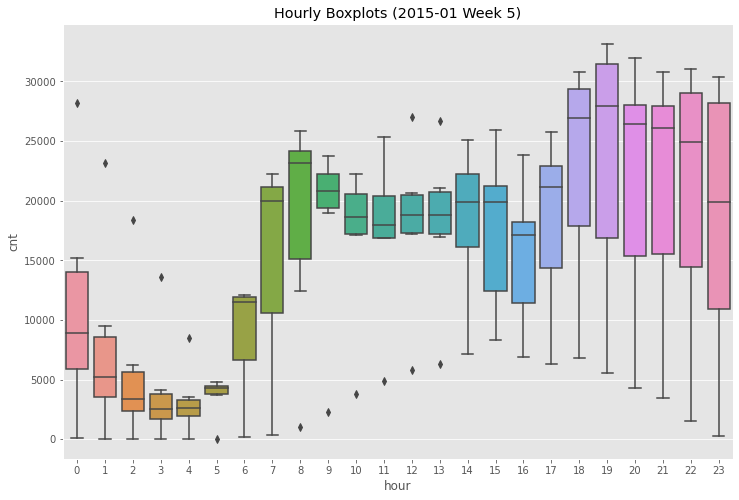

In [25]:
for weeknum in range(1,6):
    plt.figure(figsize=(12,8))
    sns.boxplot(x='hour', y='cnt', data=df[df['week']==weeknum])
    plt.title('Hourly Boxplots (2015-01 Week {})'.format(weeknum))

### Hourly Boxplots by Day of Week

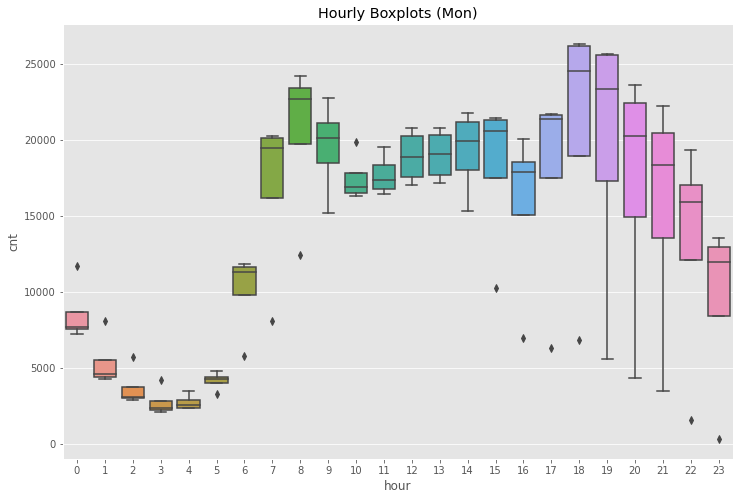

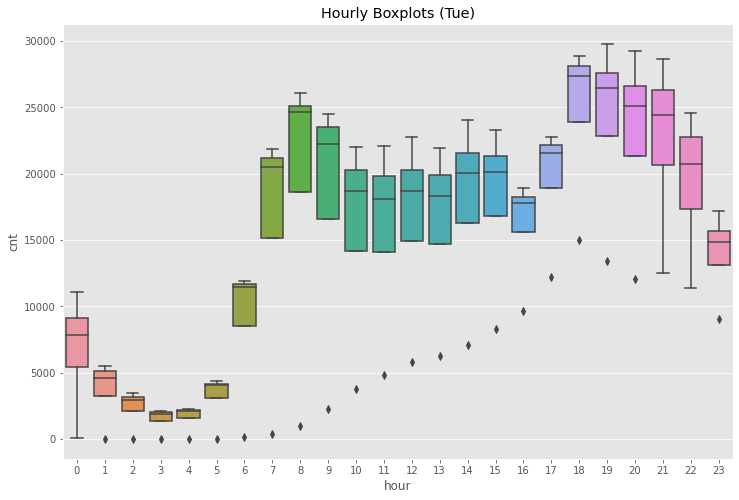

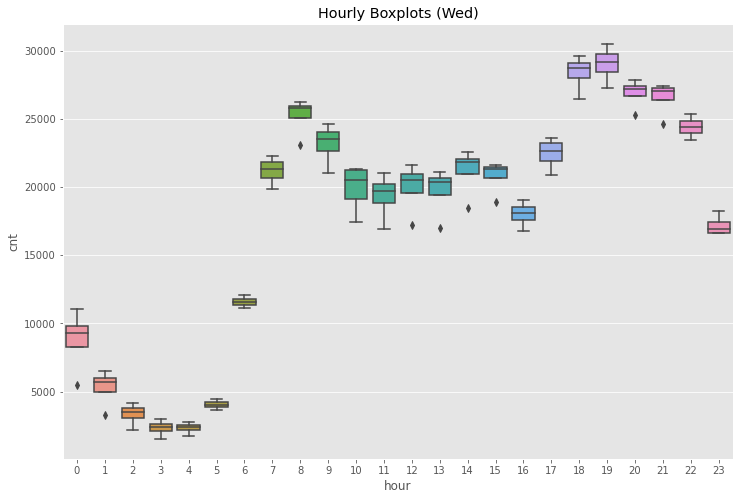

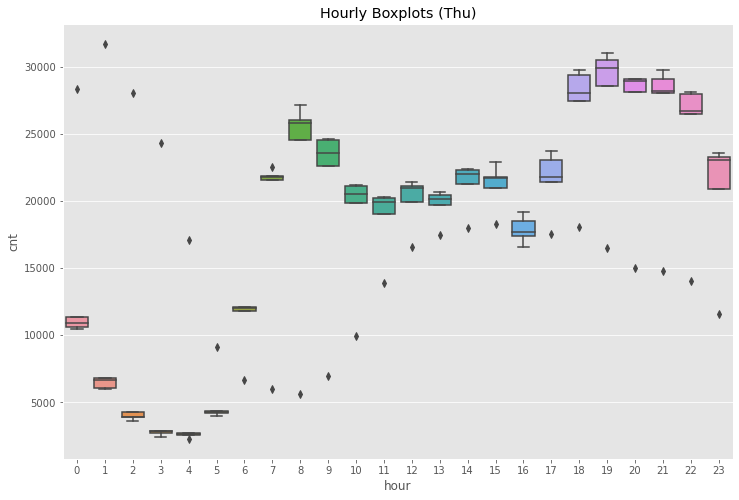

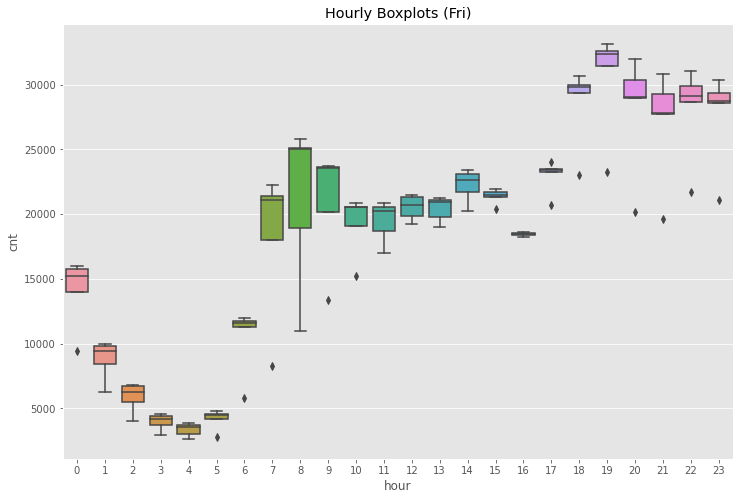

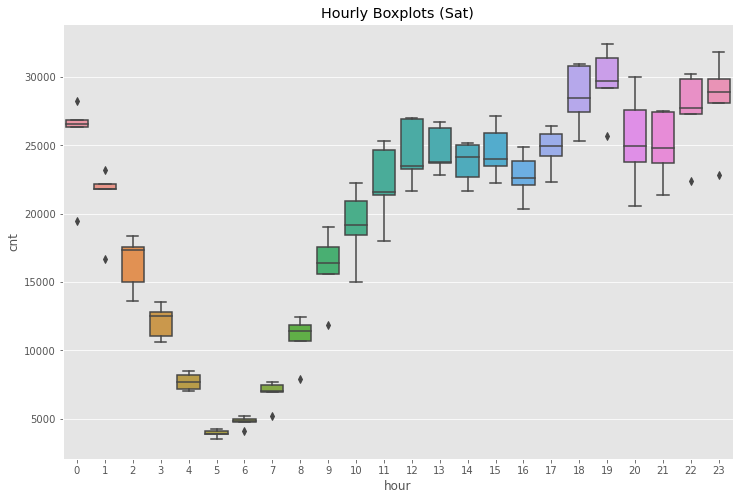

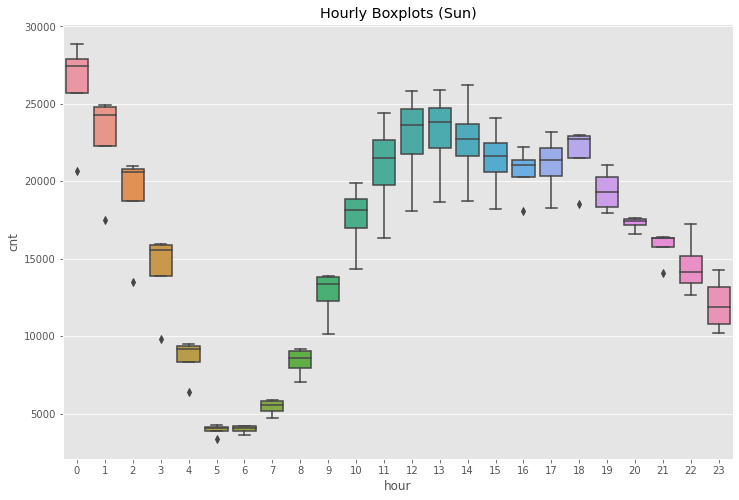

In [26]:
for day in range(7):
    plt.figure(figsize=(12,8))
    sns.boxplot(x='hour', y='cnt', data=df[df['dow']==day])
    plt.title('Hourly Boxplots ({})'.format(dow_dict[day]))

### Hourly Boxplots for Weekends/Weekdays

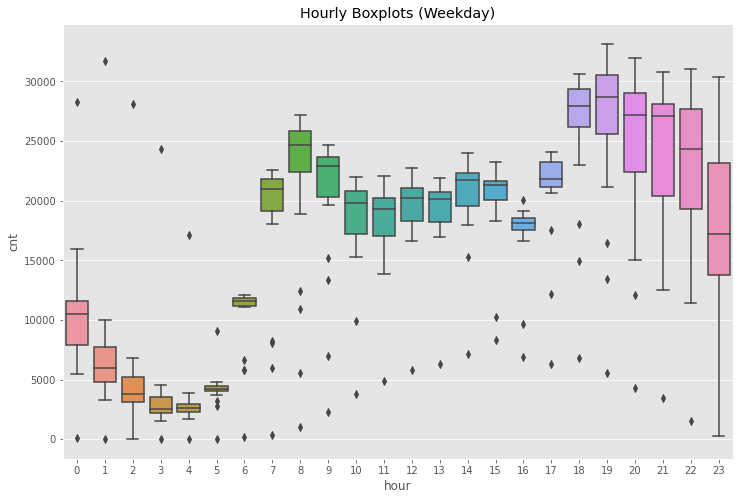

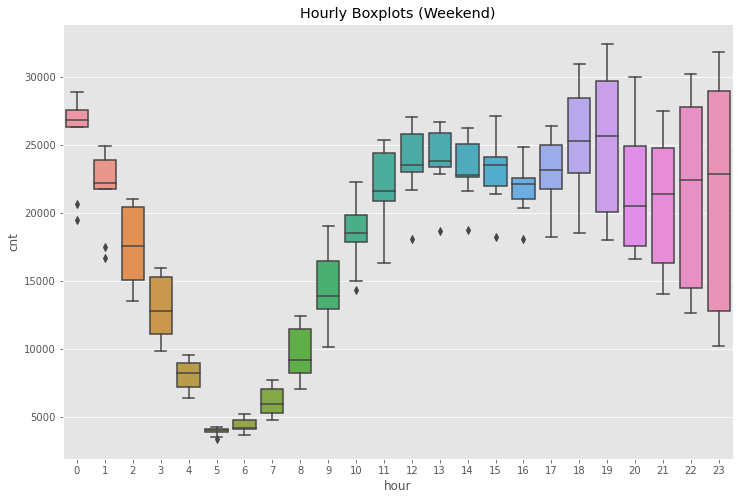

In [27]:
wkend_list = ['Weekday','Weekend']
for flag in range(2):
    plt.figure(figsize=(12,8))
    sns.boxplot(x='hour', y='cnt', data=df[df['is_weekend']==flag])
    plt.title('Hourly Boxplots ({})'.format(wkend_list[flag]))

### Trip Distance Distribution

In [28]:
%%time

trip_dist_query = '''
                  SELECT FLOOR(trip_distance/30)*30 AS bucket_floor,
                         count(1) AS count
                  FROM `bigquery-public-data.new_york_taxi_trips.tlc_yellow_trips_2015` 
                  WHERE EXTRACT(MONTH FROM pickup_datetime) = 1
                  GROUP BY bucket_floor
                  ORDER BY bucket_floor
                  '''

safe_config = bigquery.QueryJobConfig(maximum_bytes_billed = 10**10)
dist_query_job = client.query(trip_dist_query, job_config=safe_config)
dist_df = dist_query_job.to_dataframe()

CPU times: user 18.7 ms, sys: 2.21 ms, total: 20.9 ms
Wall time: 2.59 s


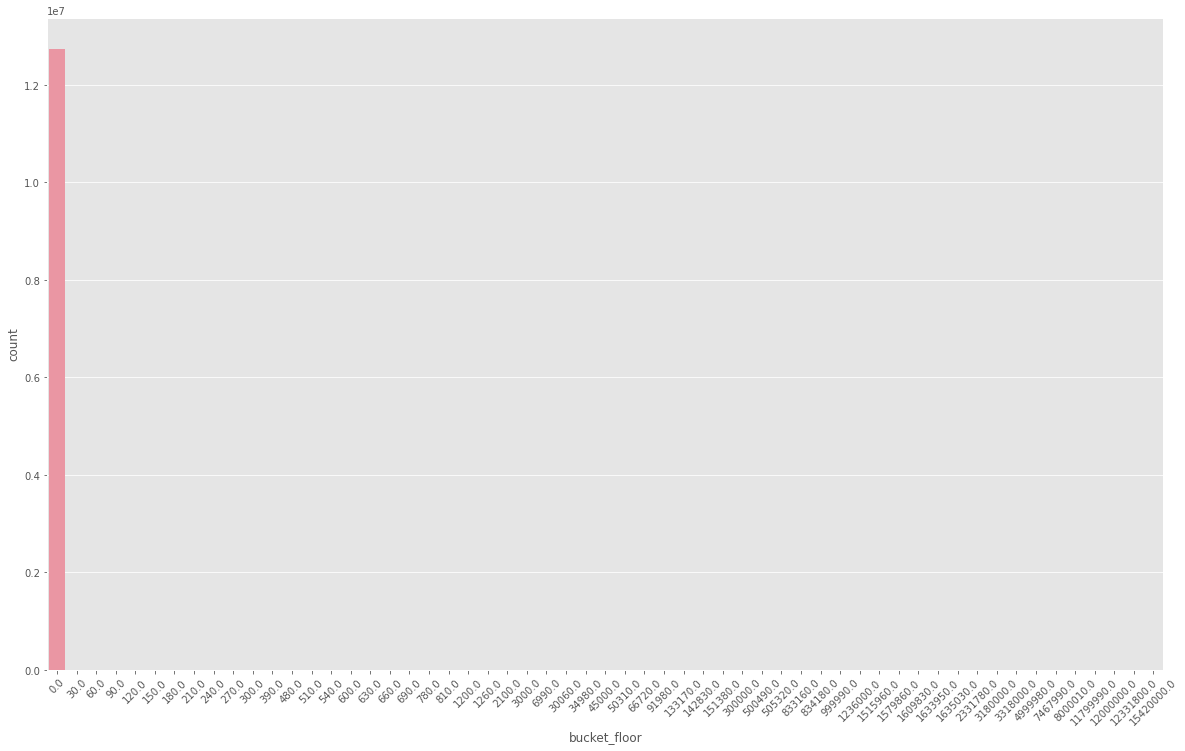

In [29]:
plt.figure(figsize=(20,12))
sns.barplot(x='bucket_floor', y='count', data=dist_df)
plt.xticks(rotation=45);

In [30]:
%%time
trip_dist_log_query = '''
                      SELECT FLOOR(trip_distance/30)*30 AS bucket_floor,
                             LOG10(COUNT(1)) AS count_log
                      FROM `bigquery-public-data.new_york_taxi_trips.tlc_yellow_trips_2015` 
                      WHERE EXTRACT(MONTH FROM pickup_datetime) = 1
                      GROUP BY bucket_floor
                      ORDER BY bucket_floor
                      '''

safe_config = bigquery.QueryJobConfig(maximum_bytes_billed = 10**10)
dist_log_query_job = client.query(trip_dist_log_query, job_config=safe_config)
dist_log_df = dist_log_query_job.to_dataframe()

CPU times: user 20 ms, sys: 1.14 ms, total: 21.2 ms
Wall time: 2.65 s


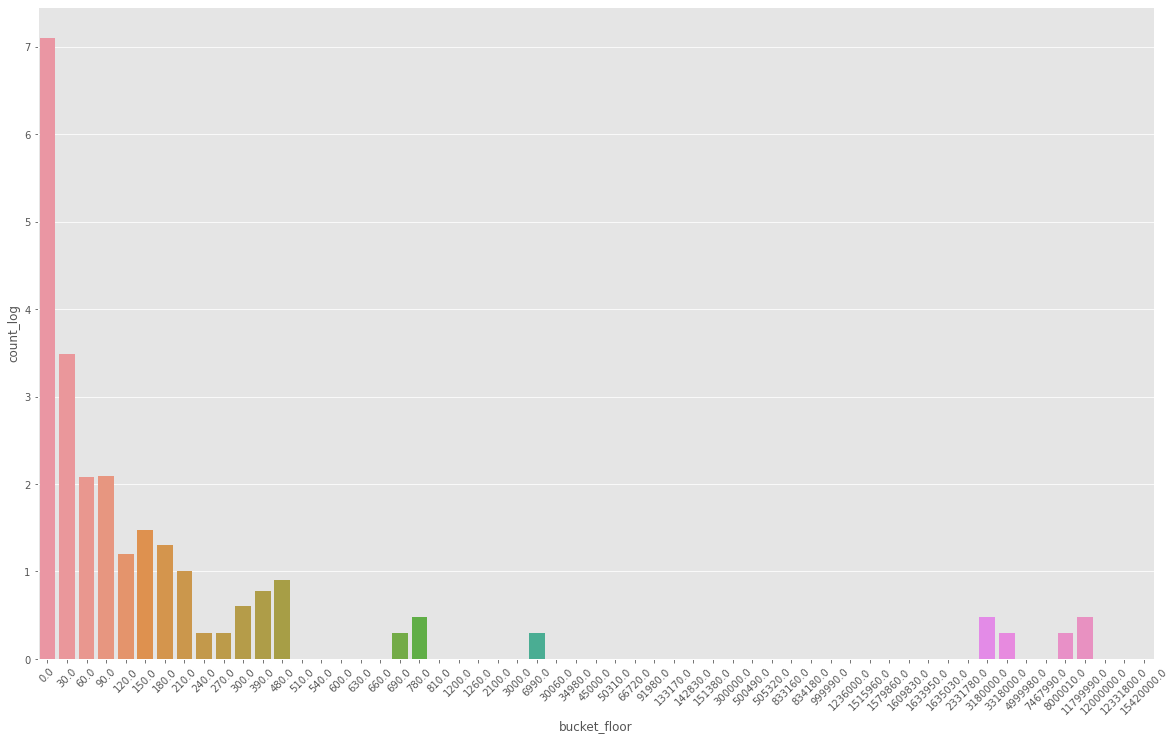

In [31]:
plt.figure(figsize=(20,12))
sns.barplot(x='bucket_floor', y='count_log', data=dist_log_df)
plt.xticks(rotation=45);

In [32]:
dist_df.head()

,bucket_floor,count
0,0.0,12745563
1,30.0,3027
2,60.0,120
3,90.0,124
4,120.0,16


We can see that majority of the trips have distance under 30. Let's divide trips into two groups: short trips (<30) and long trips (>=30).

### Short/Long Trips

In [33]:
%%time
short_query = '''
              SELECT EXTRACT(HOUR FROM pickup_datetime) AS pickup_hour,
                     EXTRACT(HOUR FROM dropoff_datetime) AS dropoff_hour,
                     COUNT(1) AS count
              FROM `bigquery-public-data.new_york_taxi_trips.tlc_yellow_trips_2015`
              WHERE EXTRACT(MONTH FROM pickup_datetime) = 1
              AND trip_distance < 30
              GROUP BY pickup_hour, dropoff_hour
              '''

safe_config = bigquery.QueryJobConfig(maximum_bytes_billed = 10**10)
short_query_job = client.query(short_query, job_config = safe_config)
short_trip_df = short_query_job.to_dataframe()

CPU times: user 21.6 ms, sys: 1.95 ms, total: 23.6 ms
Wall time: 1.1 s


In [ ]:
%%time
long_query = '''
             SELECT EXTRACT(HOUR FROM pickup_datetime) AS pickup_hour,
                    EXTRACT(HOUR FROM dropoff_datetime) AS dropoff_hour,
                    COUNT(1) AS count
             FROM `bigquery-public-data.new_york_taxi_trips.tlc_yellow_trips_2015`
             WHERE EXTRACT(MONTH from pickup_datetime) = 1
             AND trip_distance >= 30
             GROUP BY pickup_hour, dropoff_hour
             '''

safe_config = bigquery.QueryJobConfig(maximum_bytes_billed = 10**10)
long_query_job = client.query(long_query, job_config=safe_config)
long_trip_df = long_query_job.to_dataframe()

CPU times: user 20.4 ms, sys: 3.17 ms, total: 23.6 ms
Wall time: 1.15 s


In [ ]:
short_trip_df.head()

In [ ]:
long_trip_df.head()

In [ ]:
trip_df = short_trip_df.merge(long_trip_df, on=['pickup_hour','dropoff_hour'], suffixes=['_short','_long'])\
                   .rename(columns={'count_short':'short_trips', 'count_long':'long_trips'})

trip_df.head()

In [ ]:
trip_df_pickup = trip_df.groupby(['pickup_hour'])[['short_trips','long_trips']].sum().reset_index()
trip_df_dropoff = trip_df.groupby(['dropoff_hour'])[['short_trips','long_trips']].sum().reset_index()

In [ ]:
trip_df_pickup.head()

In [ ]:
trip_df_dropoff.head()

In [ ]:
def plt_clock(ax, radii, title, color):
    N = 24
    bottom = 2

    # theta for 24 hours
    theta = np.linspace(0.0, 2 * np.pi, N, endpoint=False)

    # bin width
    width = 2*np.pi / N
    
    bars = ax.bar(theta, radii, width=width, bottom=bottom, color=color, edgecolor="#999999")

    # start from north
    ax.set_theta_zero_location("N")
    # clockwise
    ax.set_theta_direction(-1)

    # set labels
    ax.set_xticks(theta)
    ticks = ["{}:00".format(x) for x in range(24)]
    ax.set_xticklabels(ticks)
    ax.set_title(title)

In [ ]:
fig, ax = plt.subplots(2, 2, figsize=(18,18), subplot_kw={'polar':True})

radii = np.array(trip_df_pickup['short_trips'].tolist(), dtype="int64")
title = 'Pickup Time for Short Trips'
plt_clock(ax[0][0], radii, title, 'coral')

radii = np.array(trip_df_pickup['long_trips'].tolist(), dtype="int64")
title = 'Pickup Time for Long Trips'
plt_clock(ax[0][1], radii, title, 'skyblue')

radii = np.array(trip_df_dropoff['short_trips'].tolist(), dtype="int64")
title = 'Dropoff Time for Short Trips'
plt_clock(ax[1][0], radii, title, 'coral')

radii = np.array(trip_df_dropoff['long_trips'].tolist(), dtype="int64")
title = 'Dropoff Time for Long Trips'
plt_clock(ax[1][1], radii, title, 'skyblue')

Peak times
- Short trips: 18:00 ~ 22:00
- Long trips: 13:00 ~ 17:00